# XGBoost Model for Rental Price

This notebook trains an XGBoost regressor to predict `rental_price` using the dataset:
`data/curated/rent_features/cleaned_listings_isochrones_added_with_best_schools.csv`.

It loads and preprocesses the data, splits into train/validation/test, fits the model,
evaluates metrics, and inspects feature importances.

In [63]:
# Imports
import os, sys, inspect
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin

# XGBoost
try:
    from xgboost import XGBRegressor
    try:
        # Preferred in newer XGBoost versions (>=2.x/3.x)
        from xgboost.callback import EarlyStopping as XGB_EarlyStopping
    except Exception:
        XGB_EarlyStopping = None
except Exception as e:
    print("xgboost is not installed. Install with: pip install xgboost")
    raise

np.random.seed(42)
sns.set_theme(style="whitegrid")


In [64]:
# Locate and load the dataset (supports running from repo root or notebooks/)
DATA_PATHS = [
    Path('data/curated/rent_features/cleaned_listings_isochrones_added_with_best_schools.csv'),
    Path('../data/curated/rent_features/cleaned_listings_isochrones_added_with_best_schools.csv'),
]
csv_path = None
for p in DATA_PATHS:
    if p.exists():
        csv_path = p
        break
if csv_path is None:
    raise FileNotFoundError(
        "Could not find CSV at expected paths: " + ", ".join(map(str, DATA_PATHS))
    )

# Optional sampling to speed up experimentation on large files
USE_SAMPLE = False   # set True to sample a subset for quick runs
SAMPLE_FRAC = 0.2
SAMPLE_RANDOM_STATE = 42

read_csv_kwargs = dict(low_memory=False)
df = pd.read_csv(csv_path, **read_csv_kwargs)
if USE_SAMPLE:
    df = df.sample(frac=SAMPLE_FRAC, random_state=SAMPLE_RANDOM_STATE).reset_index(drop=True)

print(f"Loaded {csv_path} with shape: {df.shape}")
df.head(3)


Loaded ../data/curated/rent_features/cleaned_listings_isochrones_added_with_best_schools.csv with shape: (14497, 318)


,property_id,rental_price,bedrooms,bathrooms,car_spaces,property_type,suburb,year,quarter,longitude,...,best_school_name_walking_10min,best_school_coord_walking_10min,best_score_walking_10min,best_dist_km_walking_10min,n_schools_walking_10min,best_school_name_walking_15min,best_school_coord_walking_15min,best_score_walking_15min,best_dist_km_walking_15min,n_schools_walking_15min
0,17391397,530.0,2,1,1,Apartment / Unit / Flat,travancore,2025,1,144.938692,...,Mount Alexander 7-12 College,POINT (144.93324 -37.78215),-8.930718e-05,0.598654,5.0,St Michaels Primary School,POINT (144.94625 -37.7933),7.012272e-02,1.103585,9.0
1,15861446,380.0,2,1,1,Apartment / Unit / Flat,oak park-glenroy-fawkner,2022,2,144.915633,...,NaN,NaN,3.000000e-08,16.218622,0.0,NaN,NaN,3.000000e-08,6.245875,NaN
2,17522383,650.0,2,1,1,Apartment / Unit / Flat,east melbourne,2025,1,144.986005,...,Collingwood College,POINT (144.9905 -37.80298),-8.504267e-05,0.879401,2.0,Collingwood College,POINT (144.9905 -37.80298),-8.504267e-05,0.879401,2.0


In [65]:
# Target: ensure numeric, drop NAs, and filter outliers
if 'rental_price' not in df.columns:
    raise KeyError("Column 'rental_price' not found in data.")

df['rental_price'] = pd.to_numeric(df['rental_price'], errors='coerce')
df = df.dropna(subset=['rental_price']).reset_index(drop=True)

# Target outlier filtering (configure as needed)
FILTER_TARGET_OUTLIERS = True
TARGET_FILTER_METHOD = 'quantile'  # 'quantile' or 'fixed'
TARGET_Q_LOW = 0.01
TARGET_Q_HIGH = 0.99
TARGET_FIXED_RANGE = (100, 3000)  # used when method == 'fixed'

if FILTER_TARGET_OUTLIERS:
    if TARGET_FILTER_METHOD == 'quantile':
        low = float(df['rental_price'].quantile(TARGET_Q_LOW))
        high = float(df['rental_price'].quantile(TARGET_Q_HIGH))
    elif TARGET_FILTER_METHOD == 'fixed':
        low, high = TARGET_FIXED_RANGE
    else:
        raise ValueError("Unknown TARGET_FILTER_METHOD; use 'quantile' or 'fixed'")
    before = len(df)
    mask = (df['rental_price'] >= low) & (df['rental_price'] <= high)
    df = df.loc[mask].reset_index(drop=True)
    print(f"Filtered target to [{low:.2f}, {high:.2f}] — kept {len(df)}/{before} rows")

# Keep raw target and allow optional log transform later
y_raw = df['rental_price'].astype(float)
X = df.drop(columns=['rental_price'])

# Drop common identifier/free-text columns if present (avoids huge one-hot)
drop_if_present = [
    'id','ID','listing_id','property_id','address','url','link','description','title',
    'full_address','street_address','listing_url','latlon_str','geometry','geom','wkt'
]
cols_to_drop = [c for c in drop_if_present if c in X.columns]
if cols_to_drop:
    X = X.drop(columns=cols_to_drop)

print('Feature matrix shape:', X.shape, '| Target length:', len(y_raw))
X.head(3)


Filtered target to [220.00, 1695.20] — kept 14214/14497 rows
Feature matrix shape: (14214, 316) | Target length: 14214


,bedrooms,bathrooms,car_spaces,property_type,suburb,year,quarter,longitude,latitude,closest_ptv_station_id,...,best_school_name_walking_10min,best_school_coord_walking_10min,best_score_walking_10min,best_dist_km_walking_10min,n_schools_walking_10min,best_school_name_walking_15min,best_school_coord_walking_15min,best_score_walking_15min,best_dist_km_walking_15min,n_schools_walking_15min
0,2,1,1,Apartment / Unit / Flat,travancore,2025,1,144.938692,-37.785370,NaN,...,Mount Alexander 7-12 College,POINT (144.93324 -37.78215),-8.930718e-05,0.598654,5.0,St Michaels Primary School,POINT (144.94625 -37.7933),7.012272e-02,1.103585,9.0
1,2,1,1,Apartment / Unit / Flat,oak park-glenroy-fawkner,2022,2,144.915633,-37.703150,NaN,...,NaN,NaN,3.000000e-08,16.218622,0.0,NaN,NaN,3.000000e-08,6.245875,NaN
2,2,1,1,Apartment / Unit / Flat,east melbourne,2025,1,144.986005,-37.810055,NaN,...,Collingwood College,POINT (144.9905 -37.80298),-8.504267e-05,0.879401,2.0,Collingwood College,POINT (144.9905 -37.80298),-8.504267e-05,0.879401,2.0


In [66]:
# Identify feature types

# set categorical features
categorical_features = [
    'property_type', 'suburb'
]

# set numerical features
numeric_features = [
    'bedrooms', 'bathrooms', 'car_spaces',
    'year', 'quarter',
    'best_score_walking_5min', 'best_score_walking_10min', 
    'best_score_walking_15min', 'best_dist_km_driving_5min', 'best_dist_km_driving_10min',
    'best_dist_km_driving_15min', 'best_dist_km_walking_5min', 'best_dist_km_walking_10min',
    'best_dist_km_walking_15min', 'n_schools_driving_5min', 'n_schools_driving_10min',
    'n_schools_driving_15min', 'n_schools_walking_5min', 'n_schools_walking_10min',
    'n_schools_walking_15min', 'missing_iso_feature'
]

print(f"Categorical: {len(categorical_features)} | Numeric: {len(numeric_features)}")

Categorical: 2 | Numeric: 21


In [67]:
# Only keep listed features
X = X[categorical_features + numeric_features]
print('Reduced feature matrix shape:', X.shape)
X

Reduced feature matrix shape: (14214, 23)


,property_type,suburb,bedrooms,bathrooms,car_spaces,year,quarter,best_score_walking_5min,best_score_walking_10min,best_score_walking_15min,...,best_dist_km_walking_5min,best_dist_km_walking_10min,best_dist_km_walking_15min,n_schools_driving_5min,n_schools_driving_10min,n_schools_driving_15min,n_schools_walking_5min,n_schools_walking_10min,n_schools_walking_15min,missing_iso_feature
0,Apartment / Unit / Flat,travancore,2,1,1,2025,1,-8.930718e-05,-8.930718e-05,7.012272e-02,...,0.598654,0.598654,1.103585,14.0,59.0,125.0,5.0,5.0,9.0,0
1,Apartment / Unit / Flat,oak park-glenroy-fawkner,2,1,1,2022,2,3.000000e-08,3.000000e-08,3.000000e-08,...,16.218622,16.218622,6.245875,NaN,NaN,NaN,0.0,0.0,NaN,0
2,Apartment / Unit / Flat,east melbourne,2,1,1,2025,1,-8.504267e-05,-8.504267e-05,-8.504267e-05,...,0.879401,0.879401,0.879401,15.0,57.0,142.0,2.0,2.0,2.0,0
3,apartment / unit / flat,mill park-epping,2,2,1,2025,3,-8.855220e-05,-8.855220e-05,-8.855220e-05,...,0.646387,0.646387,0.646387,10.0,38.0,128.0,2.0,2.0,2.0,0
4,House,hampton east,2,1,2,2024,4,4.899245e-01,4.899245e-01,3.000000e-08,...,1.645922,1.645922,6.245875,6.0,36.0,77.0,1.0,3.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14209,house,elsternwick,3,1,2,2025,3,2.994082e-01,2.994082e-01,2.994082e-01,...,0.352225,0.352225,0.352225,14.0,57.0,111.0,1.0,1.0,3.0,0
14210,house,frankston north,3,1,2,2025,3,6.609453e-02,6.609453e-02,3.000000e-08,...,0.998983,0.998983,6.245875,4.0,15.0,44.0,1.0,1.0,1.0,0
14211,townhouse,altona meadows,2,2,1,2025,3,-5.648924e-05,-5.648924e-05,3.000000e-08,...,3.851243,3.851243,6.245875,3.0,14.0,39.0,14.0,1.0,1.0,0
14212,townhouse,shepparton,3,2,1,2025,3,-8.218382e-05,-8.218382e-05,-8.218382e-05,...,1.083923,1.083923,1.083923,10.0,19.0,26.0,5.0,1.0,5.0,0


In [68]:
# quickly clean property_type
# was missed in earlier cleaning steps
if 'property_type' in X.columns:
    X['property_type'] = X['property_type'].str.lower().str.strip()
    common_types = ['house', 'apartment / unit / flat', 'townhouse', 'villa', 'duplex']
    X['property_type'] = X['property_type'].where(
        X['property_type'].isin(common_types), other='other'
    )
    print("Unique property_type values after cleaning:", X['property_type'].unique())

Unique property_type values after cleaning: ['apartment / unit / flat' 'house' 'townhouse' 'other' 'villa' 'duplex']


In [69]:
# fill missing numeric with 0 for n_schools
for col in numeric_features:
    if col.startswith('n_schools_'):
        X[col] = X[col].fillna(0)

In [70]:
# Identify feature types with a guard against high-cardinality categoricals
# numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
# categorical_candidates = X.columns.difference(numeric_features)

# max_unique_cats = 100  # avoid exploding OHE on huge text-like columns
# categorical_features, dropped_high_cardinality = [], []
# for col in categorical_candidates:
#     nunique = X[col].nunique(dropna=True)
#     if nunique <= max_unique_cats:
#         categorical_features.append(col)
#     else:
#         dropped_high_cardinality.append(col)

# print(f"Numeric features: {len(numeric_features)}")
# print(f"Categorical features (<= {max_unique_cats} levels): {len(categorical_features)}")
# if dropped_high_cardinality:
#     print(f"Dropping {len(dropped_high_cardinality)} high-cardinality columns (sample): {dropped_high_cardinality[:10]}")


In [71]:
# Build preprocessors (impute + one-hot)
# Requires 'numeric_features' and 'categorical_features' to be defined above
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

# OneHotEncoder signature differs across sklearn versions
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', ohe),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop',
    verbose_feature_names_out=True,
)


In [72]:
# Train/val/test split
USE_LOG_TARGET = True  # if True, train on log1p(target) and evaluate on original scale

# Split using raw target first to preserve original-scale y for metrics
X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y_raw, test_size=0.4, random_state=42)
X_train, X_val, y_train_raw, y_val_raw = train_test_split(X_train, y_train_raw, test_size=0.25, random_state=42)

# Derive training targets (log or raw)
if USE_LOG_TARGET:
    y_train = np.log1p(y_train_raw)
    y_val = np.log1p(y_val_raw)
    y_test = np.log1p(y_test_raw)
else:
    y_train, y_val, y_test = y_train_raw, y_val_raw, y_test_raw

# Fit preprocessor on training data and transform all splits
preprocessor.fit(X_train)
X_train_t = preprocessor.transform(X_train)
X_val_t = preprocessor.transform(X_val)
X_test_t = preprocessor.transform(X_test)

print('Transformed shapes:', X_train_t.shape, X_val_t.shape, X_test_t.shape)


Transformed shapes: (6396, 389) (2132, 389) (5686, 389)


In [73]:
# Define and train the XGBoost regressor (with early stopping on the validation set)
xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
    eval_metric='rmse',
)

# Build fit kwargs only with supported parameters for this xgboost version
fit_sig = inspect.signature(XGBRegressor().fit)
supports_callbacks = 'callbacks' in fit_sig.parameters
supports_esr = 'early_stopping_rounds' in fit_sig.parameters

fit_kwargs = {'eval_set': [(X_val_t, y_val)]}

if supports_callbacks and XGB_EarlyStopping is not None:
    fit_kwargs['callbacks'] = [XGB_EarlyStopping(rounds=50, save_best=True, maximize=False)]
elif supports_esr:
    fit_kwargs['early_stopping_rounds'] = 50

xgb.fit(X_train_t, y_train, **fit_kwargs)

# Robust best-iteration retrieval across xgboost versions
def get_best_iter(est):
    # 1) Try estimator attributes
    for attr in ('best_iteration', 'best_ntree_limit', 'best_score', 'best_iteration_'):
        if hasattr(est, attr):
            val = getattr(est, attr)
            if val is not None:
                return attr, val
    # 2) Try Booster attributes
    try:
        b = est.get_booster()
        for attr in ('best_iteration', 'best_ntree_limit', 'best_score'):
            if hasattr(b, attr):
                val = getattr(b, attr)
                if val is not None:
                    return f'booster.{attr}', val
    except Exception:
        pass
    # 3) Derive from evals_result if available
    try:
        ev = est.evals_result()
        if isinstance(ev, dict) and len(ev)>0:
            ds = next(iter(ev))  # e.g., 'validation_0'
            metric = next(iter(ev[ds]))
            import numpy as np
            idx = int(np.argmin(ev[ds][metric]))
            return 'derived_from_evals_result', idx
    except Exception:
        pass
    return None, None

src, best = get_best_iter(xgb)
if src is None:
    # No early stopping info found. This usually means early stopping didn't trigger
    # or no eval_set/metric was provided. The model likely used all trees.
    print(f"No best iteration attribute found; using all {xgb.get_params().get('n_estimators')} estimators.")
else:
    print(f"Best iteration source: {src}; value: {best}")

# Report parameters used at the selected iteration
try:
    xgb_params = xgb.get_xgb_params()
except Exception:
    xgb_params = xgb.get_params()
wrapper_params = xgb.get_params()
# Determine how many estimators were actually used
used_estimators = wrapper_params.get('n_estimators')
try:
    import numpy as np
    if src is not None and isinstance(best, (int, np.integer)):
        if 'best_ntree_limit' in str(src):
            used_estimators = int(best)
        else:
            used_estimators = int(best) + 1
except Exception:
    pass
# Key booster hyperparameters
keys = ['objective','learning_rate','max_depth','min_child_weight','subsample','colsample_bytree','reg_alpha','reg_lambda']
key_params = {k: xgb_params.get(k) for k in keys if k in xgb_params}
print('Planned n_estimators:', wrapper_params.get('n_estimators'), '| Used (best):', used_estimators)
print('Key booster parameters:', key_params)
# If evals_result is available, print the metric value at the best iteration
try:
    ev = xgb.evals_result()
    if isinstance(ev, dict) and len(ev)>0:
        ds = next(iter(ev))
        metric = next(iter(ev[ds]))
        series = ev[ds][metric]
        idx = None
        try:
            idx = int(np.argmin(series))
        except Exception:
            pass
        # Prefer derived index if earlier found
        if src is not None and isinstance(best, (int, np.integer)):
            if 'best_ntree_limit' in str(src):
                idx = int(best) - 1 if best else None
            else:
                idx = int(best)
        if idx is not None and 0 <= idx < len(series):
            print(f"Validation metric {metric} on {ds}: best={series[idx]:.6f} at iteration={idx}")
except Exception:
    pass


[0]	validation_0-rmse:0.31580
[1]	validation_0-rmse:0.30937
[2]	validation_0-rmse:0.30353
[3]	validation_0-rmse:0.29807
[4]	validation_0-rmse:0.29425
[5]	validation_0-rmse:0.28855
[6]	validation_0-rmse:0.28381
[7]	validation_0-rmse:0.27885
[8]	validation_0-rmse:0.27439
[9]	validation_0-rmse:0.27028
[10]	validation_0-rmse:0.26598
[11]	validation_0-rmse:0.26239
[12]	validation_0-rmse:0.25877
[13]	validation_0-rmse:0.25568
[14]	validation_0-rmse:0.25293
[15]	validation_0-rmse:0.25013
[16]	validation_0-rmse:0.24764
[17]	validation_0-rmse:0.24531
[18]	validation_0-rmse:0.24315
[19]	validation_0-rmse:0.24142
[20]	validation_0-rmse:0.23959
[21]	validation_0-rmse:0.23792
[22]	validation_0-rmse:0.23647
[23]	validation_0-rmse:0.23480
[24]	validation_0-rmse:0.23339
[25]	validation_0-rmse:0.23204
[26]	validation_0-rmse:0.23075
[27]	validation_0-rmse:0.22932
[28]	validation_0-rmse:0.22839
[29]	validation_0-rmse:0.22721
[30]	validation_0-rmse:0.22623
[31]	validation_0-rmse:0.22530
[32]	validation_0-

Train metrics: {'RMSE': np.float64(69.13500244128949), 'MAE': 45.96353739630513, 'R2': 0.8950651002681635}
Val metrics:   {'RMSE': np.float64(121.61005625280848), 'MAE': 74.16508458837112, 'R2': 0.6811637324916315}
Test metrics:  {'RMSE': np.float64(112.8641018674709), 'MAE': 71.80573863359224, 'R2': 0.7083402399531863}


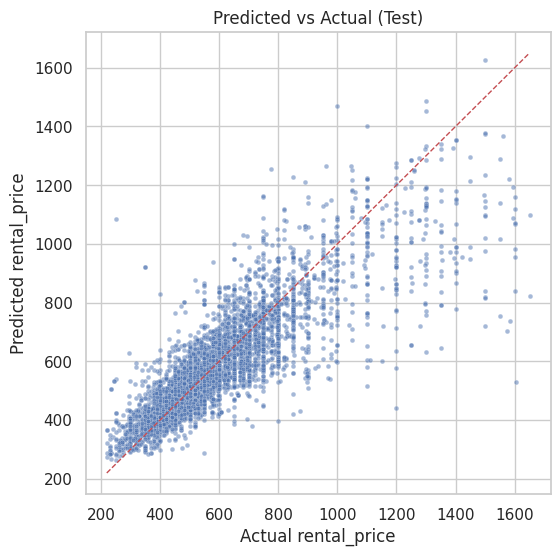

In [74]:
# Evaluate performance
def regression_metrics(y_true, y_pred):
    # Handle sklearn versions without the 'squared' kwarg
    mse_sig = inspect.signature(mean_squared_error)
    if 'squared' in mse_sig.parameters:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    else:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Raw predictions from the model (in log scale if USE_LOG_TARGET)
y_train_pred = xgb.predict(X_train_t)
y_val_pred = xgb.predict(X_val_t)
y_test_pred = xgb.predict(X_test_t)

# Convert predictions back to original scale when needed
if 'USE_LOG_TARGET' in globals() and USE_LOG_TARGET:
    y_train_eval = np.expm1(y_train_pred)
    y_val_eval = np.expm1(y_val_pred)
    y_test_eval = np.expm1(y_test_pred)
    yt_train = y_train_raw
    yt_val = y_val_raw
    yt_test = y_test_raw
else:
    y_train_eval, y_val_eval, y_test_eval = y_train_pred, y_val_pred, y_test_pred
    yt_train, yt_val, yt_test = y_train, y_val, y_test

print('Train metrics:', regression_metrics(yt_train, y_train_eval))
print('Val metrics:  ', regression_metrics(yt_val, y_val_eval))
print('Test metrics: ', regression_metrics(yt_test, y_test_eval))

plt.figure(figsize=(6, 6))
sns.scatterplot(x=yt_test, y=y_test_eval, s=12, alpha=0.5)
lims = [min(yt_test.min(), y_test_eval.min()), max(yt_test.max(), y_test_eval.max())]
plt.plot(lims, lims, 'r--', linewidth=1)
plt.xlabel('Actual rental_price')
plt.ylabel('Predicted rental_price')
plt.title('Predicted vs Actual (Test)')
plt.show()


In [75]:
# Optional: cross-validation on the full dataset (may be slow on large files)
DO_CV = False
if DO_CV:
    model = Pipeline(steps=[('preprocessor', preprocessor), ('model', xgb)])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y_raw, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
    print('CV RMSE: ', (-cv_scores).mean(), '+/-', (-cv_scores).std())


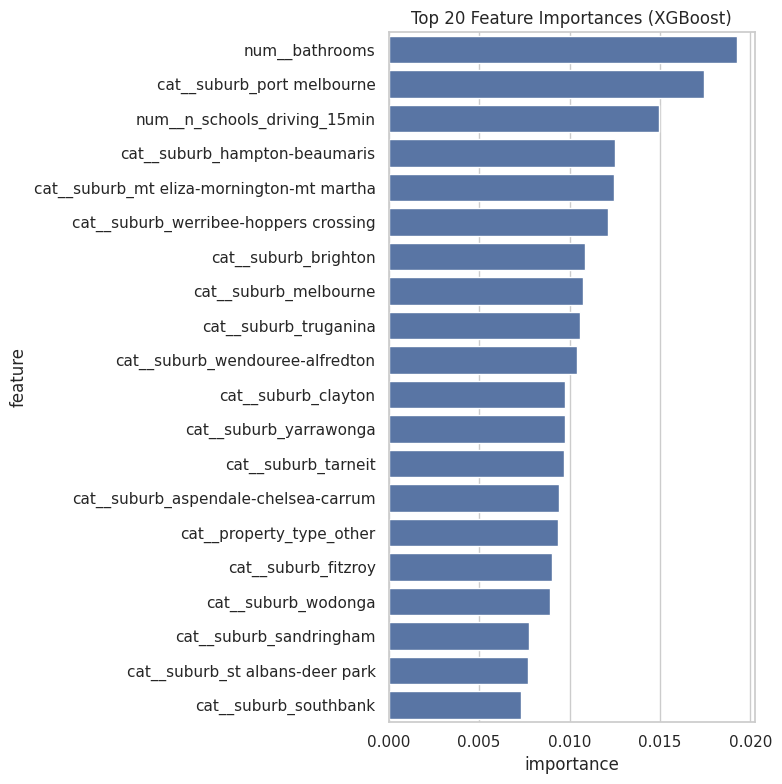

In [76]:
# Feature importances
importances = xgb.feature_importances_
try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    # Fallback: generic names if transformers don't expose names
    feature_names = np.asarray([f'feature_{i}' for i in range(importances.shape[0])], dtype=object)
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
feat_imp.head(20)

top_n = 20
plt.figure(figsize=(8, max(4, top_n * 0.4)))
sns.barplot(data=feat_imp.head(top_n), x='importance', y='feature', orient='h')
plt.title(f'Top {top_n} Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()


In [77]:
# Optional: save fitted pipeline (preprocessing + model)
from joblib import dump
save_dir = Path('models')
save_dir.mkdir(parents=True, exist_ok=True)
fitted_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', xgb)])
model_path = save_dir / 'xgb_rental_price_pipeline.joblib'
dump(fitted_pipeline, model_path)
print(f'Saved pipeline to {model_path}')


Saved pipeline to models/xgb_rental_price_pipeline.joblib


In [78]:
# Hyperparameter tuning (RandomizedSearchCV)
from sklearn.model_selection import RandomizedSearchCV, KFold

DO_TUNING = True
TUNE_SAMPLE_FRAC = 1.0   # set <1.0 to sample training data for faster tuning
N_ITER = 60
CV_FOLDS = 5
RANDOM_STATE = 42

if DO_TUNING:
    # Build a pipeline that includes preprocessing inside CV
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(
            objective='reg:squarederror',
            n_estimators=1000,
            tree_method='hist',
            random_state=RANDOM_STATE,
            n_jobs=-1,
            eval_metric='rmse',
        )),
    ])

    # Search space
    param_distributions = {
        'model__n_estimators': [800, 1200, 2000, 3000, 4000],
        'model__learning_rate': [0.01, 0.02, 0.03, 0.05],
        'model__max_depth': [4, 6, 8, 10],
        'model__min_child_weight': [1, 3, 5, 7, 10],
        'model__subsample': [0.6, 0.7, 0.8, 0.9],
        'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9],
        'model__reg_alpha': [0, 0.1, 0.3, 1.0],
        'model__reg_lambda': [0.5, 1.0, 2.0, 5.0],
        'model__gamma': [0, 0.1, 0.3, 1.0],
    }

    cv = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    X_tune, y_tune = X_train, y_train
    if TUNE_SAMPLE_FRAC and TUNE_SAMPLE_FRAC < 1.0:
        sample_idx = X_train.sample(frac=TUNE_SAMPLE_FRAC, random_state=RANDOM_STATE).index
        X_tune = X_train.loc[sample_idx]
        y_tune = y_train.loc[sample_idx] if hasattr(y_train, 'loc') else y_train[sample_idx]
        print(f'Sampled {len(X_tune)}/{len(X_train)} rows for tuning')

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=N_ITER,
        scoring='neg_root_mean_squared_error',
        cv=cv,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
        refit=True,
    )

    search.fit(X_tune, y_tune)
    best_rmse = -float(search.best_score_)
    print('Best CV RMSE:', best_rmse)
    print('Best params:')
    for k,v in sorted(search.best_params_.items()):
        print(' ', k, '=', v)

    # Evaluate best pipeline on validation and test splits (same scale as y_tune)
    best_model_cv = search.best_estimator_
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    def metrics(y_true, y_pred):
        rmse = mean_squared_error(y_true, y_pred, squared=False) if 'squared' in inspect.signature(mean_squared_error).parameters else np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

    y_val_pred_cv = best_model_cv.predict(X_val)
    y_test_pred_cv = best_model_cv.predict(X_test)
    print('Val metrics (CV-best pipeline):', metrics(y_val, y_val_pred_cv))
    print('Test metrics (CV-best pipeline):', metrics(y_test, y_test_pred_cv))

    # Refit tuned XGB on transformed matrices with early stopping, then set as active xgb
    tuned = {k.split('__',1)[1]: v for k,v in search.best_params_.items() if k.startswith('model__')}
    xgb_tuned = XGBRegressor(
        **tuned,
        objective='reg:squarederror',
        tree_method='hist',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='rmse',
    )
    fit_sig = inspect.signature(XGBRegressor().fit)
    supports_callbacks = 'callbacks' in fit_sig.parameters
    supports_esr = 'early_stopping_rounds' in fit_sig.parameters
    fit_kwargs = {'eval_set': [(X_val_t, y_val)]}
    if supports_callbacks and 'XGB_EarlyStopping' in globals() and XGB_EarlyStopping is not None:
        fit_kwargs['callbacks'] = [XGB_EarlyStopping(rounds=50, save_best=True, maximize=False)]
    elif supports_esr:
        fit_kwargs['early_stopping_rounds'] = 50
    xgb_tuned.fit(X_train_t, y_train, **fit_kwargs)

    # Make tuned model the active one for downstream metrics
    xgb = xgb_tuned
    print('Refit tuned model; best_iteration (if any):', getattr(xgb, 'best_iteration', None))


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best CV RMSE: 0.1637196796715327
Best params:
  model__colsample_bytree = 0.9
  model__gamma = 0
  model__learning_rate = 0.03
  model__max_depth = 6
  model__min_child_weight = 1
  model__n_estimators = 4000
  model__reg_alpha = 0.1
  model__reg_lambda = 1.0
  model__subsample = 0.9
Val metrics (CV-best pipeline): {'RMSE': np.float64(0.16644750077098364), 'MAE': 0.11444715666737754, 'R2': 0.7350251068815836}
Test metrics (CV-best pipeline): {'RMSE': np.float64(0.1577535590324127), 'MAE': 0.11096297502893483, 'R2': 0.7505248528100319}
[0]	validation_0-rmse:0.31877
[1]	validation_0-rmse:0.31441
[2]	validation_0-rmse:0.31005
[3]	validation_0-rmse:0.30644
[4]	validation_0-rmse:0.30283
[5]	validation_0-rmse:0.29907
[6]	validation_0-rmse:0.29543
[7]	validation_0-rmse:0.29184
[8]	validation_0-rmse:0.28865
[9]	validation_0-rmse:0.28548
[10]	validation_0-rmse:0.28240
[11]	validation_0-rmse:0.27944
[12]	validation_0-rmse:0.27658
[13]

Train metrics: {'RMSE': np.float64(44.05003036932392), 'MAE': 28.38221154323289, 'R2': 0.9573993317982944}
Val metrics:   {'RMSE': np.float64(120.60728472157628), 'MAE': 71.95362597782214, 'R2': 0.6864001704897026}
Test metrics:  {'RMSE': np.float64(110.2482595407272), 'MAE': 68.76264589184235, 'R2': 0.7217031193798555}


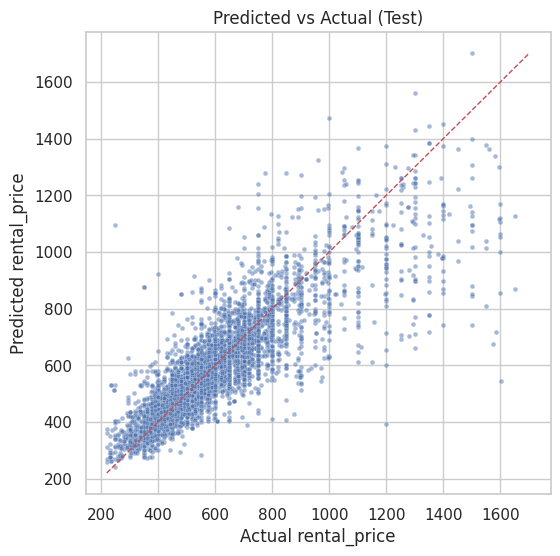

In [79]:
# Evaluate performance
def regression_metrics(y_true, y_pred):
    # Handle sklearn versions without the 'squared' kwarg
    mse_sig = inspect.signature(mean_squared_error)
    if 'squared' in mse_sig.parameters:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    else:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Raw predictions from the model (in log scale if USE_LOG_TARGET)
y_train_pred = xgb.predict(X_train_t)
y_val_pred = xgb.predict(X_val_t)
y_test_pred = xgb.predict(X_test_t)

# Convert predictions back to original scale when needed
if 'USE_LOG_TARGET' in globals() and USE_LOG_TARGET:
    y_train_eval = np.expm1(y_train_pred)
    y_val_eval = np.expm1(y_val_pred)
    y_test_eval = np.expm1(y_test_pred)
    yt_train = y_train_raw
    yt_val = y_val_raw
    yt_test = y_test_raw
else:
    y_train_eval, y_val_eval, y_test_eval = y_train_pred, y_val_pred, y_test_pred
    yt_train, yt_val, yt_test = y_train, y_val, y_test

print('Train metrics:', regression_metrics(yt_train, y_train_eval))
print('Val metrics:  ', regression_metrics(yt_val, y_val_eval))
print('Test metrics: ', regression_metrics(yt_test, y_test_eval))

plt.figure(figsize=(6, 6))
sns.scatterplot(x=yt_test, y=y_test_eval, s=12, alpha=0.5)
lims = [min(yt_test.min(), y_test_eval.min()), max(yt_test.max(), y_test_eval.max())]
plt.plot(lims, lims, 'r--', linewidth=1)
plt.xlabel('Actual rental_price')
plt.ylabel('Predicted rental_price')
plt.title('Predicted vs Actual (Test)')
plt.show()


In [80]:
if DO_CV:
    model = Pipeline(steps=[('preprocessor', preprocessor), ('model', xgb)])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y_raw, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
    print('CV RMSE: ', (-cv_scores).mean(), '+/-', (-cv_scores).std())


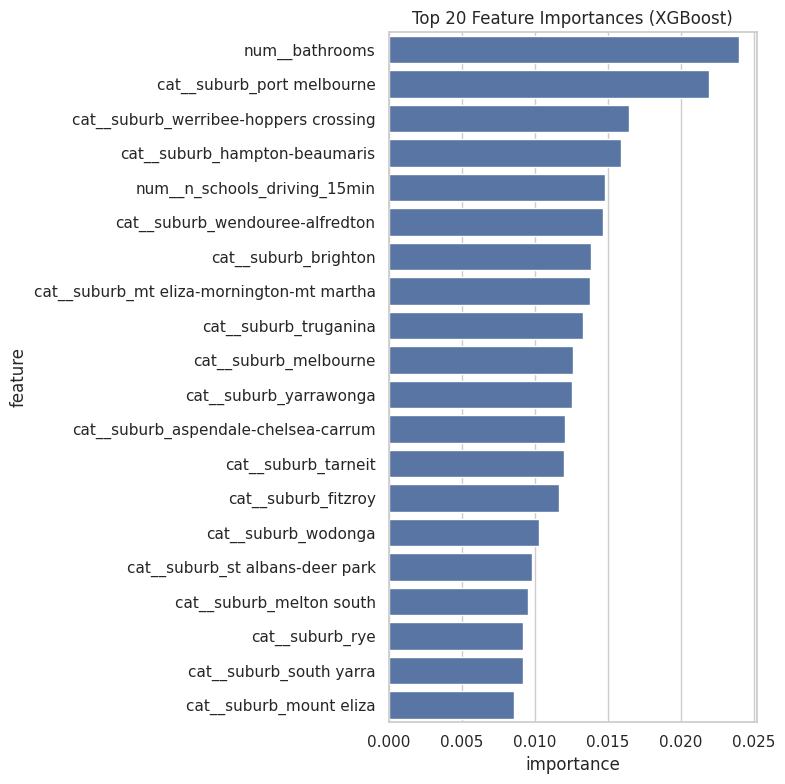

In [81]:
# Feature importances
importances = xgb.feature_importances_
try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    # Fallback: generic names if transformers don't expose names
    feature_names = np.asarray([f'feature_{i}' for i in range(importances.shape[0])], dtype=object)
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
feat_imp.head(20)

top_n = 20
plt.figure(figsize=(8, max(4, top_n * 0.4)))
sns.barplot(data=feat_imp.head(top_n), x='importance', y='feature', orient='h')
plt.title(f'Top {top_n} Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()
